This script loads in some preliminary data for the DATS 6103 final project on GDP Nowcasting.

First we'll load in the packages we need:

In [170]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

Now we'll load in the CSVs, stored in the data folder.

In [171]:
# Current new orders for service, from FRED, https://fred.stlouisfed.org/series/NOBNDIF066MSFRBPHI
# monthly, millions of dollars, seasonally adjusted
orders = pd.read_csv("../data/current_new_orders.csv")

# Employment level, from FRED, https://fred.stlouisfed.org/series/CE16OV 
# monthly, thousands of people
employ = pd.read_csv("../data/employment_level.csv")

# UMich Index of consumer sentiment, https://data.sca.isr.umich.edu/data-archive/mine.php 
# monthly, 
consumer = pd.read_csv("../data/index_of_consumer_sentiment_umich.csv", skiprows=1)

# initial unemployment claims, FRED, https://fred.stlouisfed.org/series/ICSA
# number, seasonally adjusted
claims = pd.read_csv("../data/initial_unemployment_claims.csv")

# business outlook survey, from Philly Fed, https://www.philadelphiafed.org/surveys-and-data/mbos-historical-data 
bus_outlook = pd.read_csv("../data/philly_fed_business_outlook_survey.csv")

# auto sales, from FRED, https://fred.stlouisfed.org/series/TOTALSA 
# millions of units, seasonally adjusted
auto = pd.read_csv("../data/total_auto_sales.csv")

# total construction spending, from FRED, https://fred.stlouisfed.org/series/TLMFGCONS
# millions of dollars, seasonally adjusted
construct = pd.read_csv("../data/total_construction_spending_US.csv")

# international trade, US Census, https://www.census.gov/foreign-trade/Press-Release/current_press_release/index.html
# millions of dollars, seasonally adjusted
i_trade = pd.read_excel("../data/monthly_international_trade.xlsx", skiprows = 7)

# wholesale trade, from US Census, https://www.census.gov/wholesale/data/index.html
# milliosn of dollars, seasonally adjusted
w_trade = pd.read_excel("../data/monthly_wholesale_trade.xlsx", skiprows = 7)

#import index from BLS, U.S. Import and Export Price Indexes, https://www.bls.gov/mxp/
import_index = pd.read_csv("../data/import_index.csv")
export_index = pd.read_csv("../data/export_index.csv")

# new houses sold, from U.S.Census, https://www.census.gov/construction/nrs/data/series.html
new_houses_sold = pd.read_csv("../data/new_houses_sold.csv")
#new_houses_sold.head(10)

# manufacturers new orders, from FRED, https://fred.stlouisfed.org/series/AMTMNO
manufacturers = pd.read_csv("../data/manufacturers.csv")
#manufacturers.head(10)

# capacity utilization, from FRED, https://fred.stlouisfed.org/series/TCU
capacity_utilization = pd.read_csv("../data/capacity_utilization.csv")
capacity_utilization.head(10)

# advanced retail sales, from FRED, https://fred.stlouisfed.org/series/RSXFS
advanced_retail_sales = pd.read_csv("../data/advanced_retail_sales.csv")
advanced_retail_sales.head(10)


#ppi
ppi = pd.read_csv("../data/ppi.csv")










In [172]:
# gdp is formatted weirdly so I'll load this and clean it separately

# GDP, from BEA, https://www.bea.gov/data/gdp/gross-domestic-product 
# quarterly, billions of dollars, main dependent variable
gdp = pd.read_csv("../data/gdp_bea.csv", skiprows=3)

years = gdp.columns[2:]  # start after 'Line' and blank col
years = np.floor(pd.to_numeric(years)).values

quarters = gdp.iloc[0, 2:].values

# make a combined year-quarter label
periods = [f"{int(y)}Q{int(q[-1])}" for y, q in zip(years, quarters)]

# Find the gdp row (Line 1)
gdp_row = pd.to_numeric(gdp.iloc[1, 2:].values) 

# make a df with just the date and gdp values
gdp = pd.DataFrame({
    "quarter": periods,
    "gdp": pd.to_numeric(gdp_row, errors="coerce")
})

# create a datetime column
# we have "YYYYQn", want quarterly datetime 
gdp["date"] = pd.PeriodIndex(gdp["quarter"], freq="Q").to_timestamp()

# reorder and keep only the two requested columns
gdp = gdp[["date", "gdp"]]

# make dates end of month (to be consistent with other dfs)
gdp["date"] = gdp["date"] + pd.offsets.QuarterEnd(0)



First thing I will do is clean this data and merge it into a panel. I'm going to want to a consistent datetime across all variables to merge by, and I want the main variables stored numerically. 

All of my data is monthly so I need to convert to quarterly frequency. 

In [ ]:
### orders -----------------------------------------------
orders["date"] = pd.to_datetime(orders["observation_date"])
orders = orders.set_index("date").sort_index()

# sum across months to a quarterly freq
orders_q = orders.resample("Q").sum()  # quarterly sum
# make date not the index
orders_q = orders_q.reset_index()
# select only needed cols
orders_q = orders_q[["date", "NOBNDIF066MSFRBPHI"]]

orders_q.rename(columns={'NOBNDIF066MSFRBPHI': 'orders'}, inplace=True)

### employment -----------------------------------------------
employ["date"] = pd.to_datetime(employ["observation_date"])
employ = employ.set_index("date").sort_index()

# sum across months to a quarterly freq
employ_q = employ.resample("Q").sum()  # quarterly sum
employ_q = employ_q.reset_index()

employ_q = employ_q[["date", "CE16OV"]]

employ_q.rename(columns={'CE16OV': 'employment'}, inplace=True)

### consumer -----------------------------------------------
consumer["date"] = pd.to_datetime(consumer[["Year", "Month"]].assign(day=1))

consumer["date"] = pd.to_datetime(consumer["date"])
consumer = consumer.set_index("date").sort_index()

# average across months to a quarterly freq
consumer_q = consumer.resample("Q").mean()  # quarterly average
consumer_q = consumer_q.reset_index()

consumer_q = consumer_q[["date", "Index"]]

consumer_q.rename(columns={'Index': 'consumer_sentiment'}, inplace=True)


### claims -----------------------------------------------
claims["date"] = pd.to_datetime(claims["observation_date"])
claims = claims.set_index("date").sort_index()

# sum across months to a quarterly freq
claims_q = claims.resample("Q").sum()  # quarterly sum
claims_q = claims_q.reset_index()

claims_q = claims_q[["date", "ICSA"]]

claims_q.rename(columns={'ICSA': 'unemploy_claims'}, inplace=True)


### bus_outlook -----------------------------------------------
bus_outlook["date"] = pd.to_datetime(bus_outlook["DATE"], format="%b-%y")
# fix some future years
bus_outlook.loc[bus_outlook["date"].dt.year > 2025, "date"] -= pd.DateOffset(years=100)

bus_outlook = bus_outlook.set_index("date").sort_index()
bus_outlook = bus_outlook[["GAC"]]

# average across months to a quarterly freq
bus_outlook_q = bus_outlook.resample("Q").mean()  # quarterly average
bus_outlook_q = bus_outlook_q.reset_index()

bus_outlook_q = bus_outlook_q[["date", "GAC"]]

bus_outlook_q.rename(columns={'GAC': 'bus_outlook'}, inplace=True)

### auto -----------------------------------------------
auto["date"] = pd.to_datetime(auto["observation_date"])
auto = auto.set_index("date").sort_index()

# sum across months to a quarterly freq
auto_q = auto.resample("Q").sum()  # quarterly sum
auto_q = auto_q.reset_index()

auto_q = auto_q[["date", "TOTALSA"]]

auto_q.rename(columns={'TOTALSA': 'auto_sales'}, inplace=True)


### construct -----------------------------------------------
construct["date"] = pd.to_datetime(construct["observation_date"])
construct = construct.set_index("date").sort_index()

# sum across months to a quarterly freq
construct_q = construct.resample("Q").sum()  # quarterly sum
construct_q = construct_q.reset_index()

construct_q = construct_q[["date", "TLMFGCONS"]]

construct_q.rename(columns={'TLMFGCONS': 'construction'}, inplace=True)


### i_trade -----------------------------------------------
i_trade["date"] = pd.to_datetime(i_trade["Period"], format="%b-%Y")
i_trade = i_trade.set_index("date").sort_index()

# sum across months to a quarterly freq
i_trade_q = i_trade.resample("Q").sum()
i_trade_q = i_trade_q.reset_index()

i_trade_q = i_trade_q[["date", "Value"]]

i_trade_q.rename(columns={'Value': 'itrade'}, inplace=True)

### w_trade -----------------------------------------------
w_trade["date"] = pd.to_datetime(w_trade["Period"], format="%b-%Y")
w_trade = w_trade.set_index("date").sort_index()

# sum across months to a quarterly freq
w_trade_q = w_trade.resample("Q").sum()
w_trade_q = w_trade_q.reset_index()

w_trade_q = w_trade_q[["date", "Value"]]

w_trade_q.rename(columns={'Value': 'wtrade'}, inplace=True)


### new houses sold  -------------------------------------------------
new_houses_sold["date"] = pd.to_datetime(new_houses_sold["Date"], format="%b %Y")
new_houses_sold = new_houses_sold.set_index("date").sort_index()
houses_q = new_houses_sold.resample("QE").sum().reset_index()
houses_q = houses_q[["date", "Thousands of homes sold per month"]]
houses_q = houses_q.rename(columns={"Thousands of homes sold per month": "new_houses"})
#houses_q.head(10)

### manufacturers new orders -----------------------------------------
manufacturers["date"] = pd.to_datetime(manufacturers["observation_date"])
manufacturers = manufacturers.set_index("date").sort_index()
manufacturers_q = manufacturers["AMTMNO"].resample("QE").sum()
manufacturers_q = manufacturers_q.reset_index()
manufacturers_q = manufacturers_q.rename(columns={"AMTMNO": "new_orders"})
manufacturers_q = manufacturers_q[["date", "new_orders"]]
#manufacturers_q.head(10)

### capacity utilization -----------------------------------------
capacity_utilization["date"] = pd.to_datetime(capacity_utilization["observation_date"])
capacity_utilization = capacity_utilization.set_index("date").sort_index()
capacity_utilization_q = capacity_utilization["TCU"].resample("QE").mean()
capacity_utilization_q = capacity_utilization_q.reset_index()
capacity_utilization_q = capacity_utilization_q.rename(columns={"TCU": "cap_util"})
capacity_utilization_q = capacity_utilization_q[["date", "cap_util"]]
capacity_utilization_q.head(10)

### advanced retail sales -----------------------------------------
advanced_retail_sales["date"] = pd.to_datetime(advanced_retail_sales["observation_date"])
advanced_retail_sales = advanced_retail_sales.set_index("date").sort_index()
advanced_retail_sales_q = advanced_retail_sales["RSXFS"].resample("QE").sum()
advanced_retail_sales_q = advanced_retail_sales_q.reset_index()
advanced_retail_sales_q = advanced_retail_sales_q.rename(columns={"RSXFS": "retail_sales"})
advanced_retail_sales_q = advanced_retail_sales_q[["date", "retail_sales"]]
advanced_retail_sales_q.head(10)


ppi["date"] = pd.to_datetime(ppi["DATE"])
ppi = ppi.set_index("date").sort_index()
ppi_q = ppi["PPIACO"].resample("Q").mean().reset_index()
ppi_q = ppi_q[["date", "PPIACO"]]
ppi_q.rename(columns={'PPIACO': 'ppi'}, inplace=True)







C:\Users\adgo1\AppData\Local\Temp\ipykernel_14896\2221886254.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  orders_q = orders.resample("Q").sum()  # quarterly sum
C:\Users\adgo1\AppData\Local\Temp\ipykernel_14896\2221886254.py:19: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  employ_q = employ.resample("Q").sum()  # quarterly sum
C:\Users\adgo1\AppData\Local\Temp\ipykernel_14896\2221886254.py:33: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  consumer_q = consumer.resample("Q").mean()  # quarterly average
C:\Users\adgo1\AppData\Local\Temp\ipykernel_14896\2221886254.py:46: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  claims_q = claims.resample("Q").sum()  # quarterly sum
C:\Users\adgo1\AppData\Local\Temp\ipykernel_14896\2221886254.py:63: FutureWarning: 'Q' is deprec

TypeError: agg function failed [how->mean,dtype->object]

Now to merge into one final dataset.

In [ ]:
vars = [gdp, orders_q, employ_q, consumer_q, claims_q, bus_outlook_q, auto_q, construct_q, i_trade_q,
         w_trade_q, houses_q, manufacturers_q, capacity_utilization_q, advanced_retail_sales_q]  # list all my quarterly dfs

data = reduce(lambda left, right: pd.merge(left, right, on="date", how="outer"), vars)

# save data
data.to_csv("data_wpk.csv", index = False)

I was going to deal with missing values, but upon closer inspection it looks like we're basically good! 

Let's do some quick histograms instead.

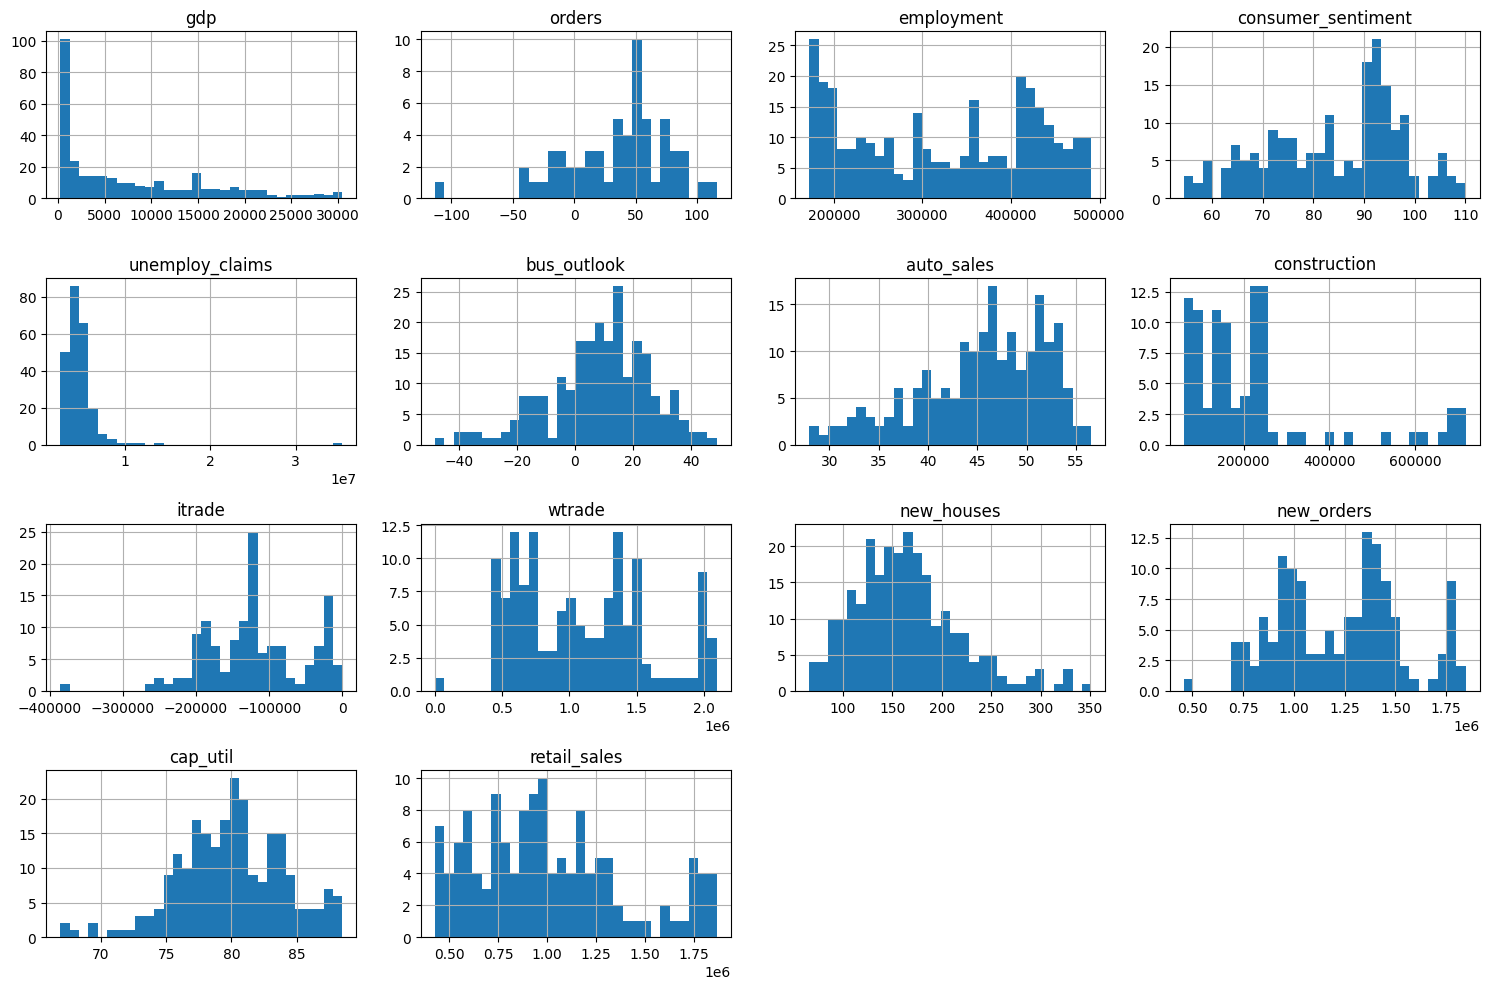

In [ ]:
numeric_cols = data.select_dtypes(include="number").columns.drop("date", errors="ignore")

data[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Now let's get an idea of the correlations between variables.

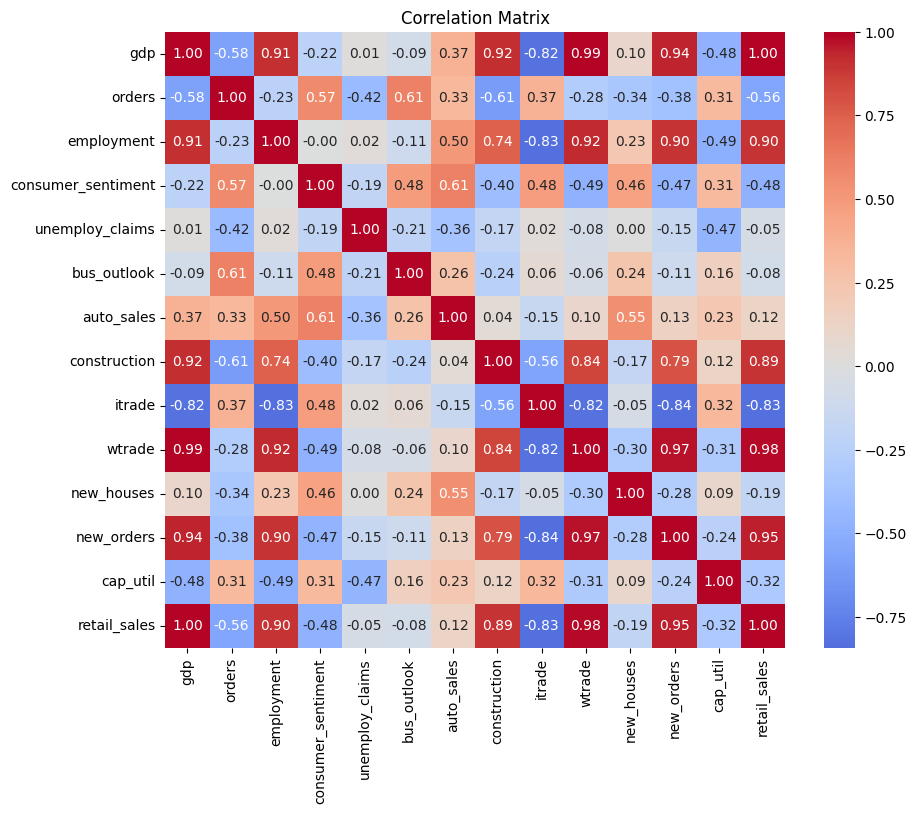

In [ ]:
corr = data.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
consumer

,Month,Year,Index,Unnamed: 3
date,,,,
1978-01-01,1,1978,83.7,NaN
1978-02-01,2,1978,84.3,NaN
1978-03-01,3,1978,78.8,NaN
1978-04-01,4,1978,81.6,NaN
1978-05-01,5,1978,82.9,NaN
...,...,...,...,...
2025-05-01,5,2025,52.2,NaN
2025-06-01,6,2025,60.7,NaN
2025-07-01,7,2025,61.7,NaN


In [ ]:
consumer_q

,date,consumer_sentiment
0,1978-03-31,82.266667
1,1978-06-30,81.500000
2,1978-09-30,80.400000
3,1978-12-31,73.466667
4,1979-03-31,71.466667
...,...,...
186,2024-09-30,68.133333
187,2024-12-31,72.100000
188,2025-03-31,64.466667
189,2025-06-30,55.033333
